# Business Understanding
Grocery stores handle large quantities of fruits every day. It's important that they are able to catagorize them and determine whether they are fresh or rotten. That's where this dataset come in. The dataset we chose is a collection of images of strawberries, peaches, and pomegranates. The images are classified as either fresh or rotten and as strawberry, peach, or pomegranete. This dataset  was likely put together in order to create training data to test image recognition algorithms on different kinds of fruits and their qualities. Although not explicitely stated within the data, it is more than likely this is the case because of the inclusion of many stock images of fruits that have watermarks and solid white backgrounds. This model could be used by grocery stores to help them catagorize their fruits and determine which ones are fresh and which ones are rotten which could help them reduce waste and increase profits. It could also be used in farming to help determine at a large scale which fruits are fresh and able to be sold, and which are rotten, and can be used for other purposes, making sure that the two do not accidentally get mixed together. This model can be used to identify the freshness of the fruit and can be handled accordingly. This data is important because of certain regulations and standards set by grocery stores and restaurants, it is crucial to not sell or serve rotten food as that would lead to serious health concerns. To be used used by these third-parties, we believe that it should be able to reliably distinguish between rotten and fresh fruits for the all the fruits included in the data set, otherwise the error would be to great and would not be of any commercial use to these companies. For example, if a shipment of pomegranites, strawberries, and peaches arrive to a restaurant, and 90% were fresh, and somehow the chef did not notice and accidentally prepared a dish with rotten fruit, that would mean that one in ten people are at risk.

# Data Understanding
Each image is a .jpg with a white background and an image size of 300*300. The classifications are stored in the file names. We did some reorganizing of the files into different folders to make it easier to read in. After loading the images, we first do some preprocessing to each image including resizing the images and then flattening th images. Finally we store the classification information in a target array.

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Classifcation categories
fruits = ['peach', 'pomegranate', 'strawberry']
fruit_type = ['fresh', 'rotten']

# Set the image size
h, w = 50, 50

# Load the image data
data_set = [] # Image data
dataset_target = [] # Target information, [fresh/rotten, fruit type]

for fruit in fruits:
    for ft in fruit_type:
        # Open the directory
        path = f'./data/{ft}/{fruit}'

        # Load the image data
        # Reading the images in as numpy arrays in a list
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))

            # Set color to RGB
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            # Resize the image
            img_array = cv2.resize(img_array, (h, w))

            # Flatten the image
            img_array = img_array.flatten()
            data_set.append(img_array)

            # Add the target information
            dataset_target.append(list([ft, fruit]))


print(f'Loaded {len(data_set)} images')
print(f'{data_set[0].shape[0]} features per image')
print("Datatype of images: ", type(data_set[0]))

Loaded 1655 images
7500 features per image
Datatype of images:  <class 'numpy.ndarray'>


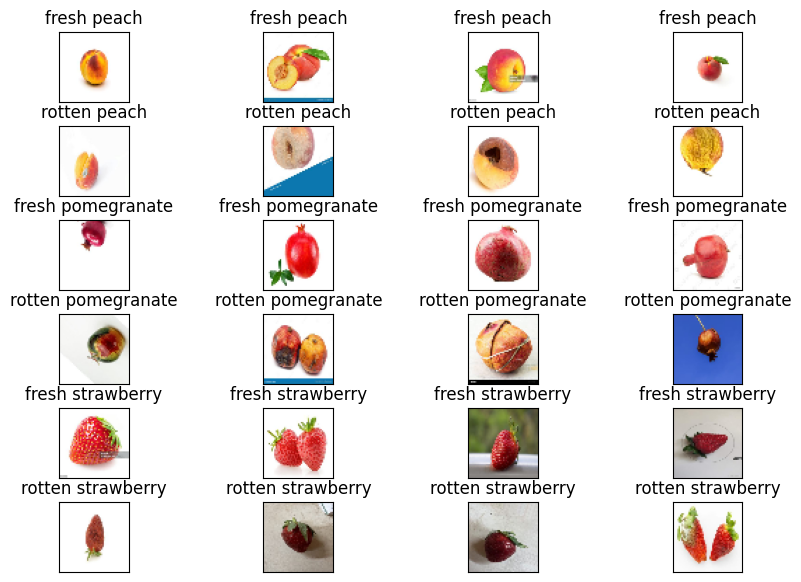

In [352]:
import random

# Plotting each row with a different fruit, including fresh and rotten rows
def plot_per_row_with_condition(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    unique_fruits = sorted(set(title[1] for title in titles))
    unique_conditions = ['fresh', 'rotten']
    num_fruits = len(unique_fruits)
    num_conditions = len(unique_conditions)

    for i, fruit in enumerate(unique_fruits):
        for j, condition in enumerate(unique_conditions):
            fruit_condition_indices = [k for k, title in enumerate(titles) if title[1] == fruit and title[0] == condition]
            plot_indices = random.sample(fruit_condition_indices, min(n_col, len(fruit_condition_indices)))

            for k, index in enumerate(plot_indices):
                plt.subplot(num_fruits * num_conditions, n_col, (i * num_conditions + j) * n_col + k + 1)
                plt.imshow(images[index].reshape((h, w, 3)))
                title = titles[index][0] + " " + titles[index][1]
                plt.title(title, size=12)
                plt.xticks(())
                plt.yticks(())

# Use the updated function to plot images with each row representing a different fruit, both fresh and rotten
plot_per_row_with_condition(data_set, dataset_target, h, w)
plt.show()



# PCA

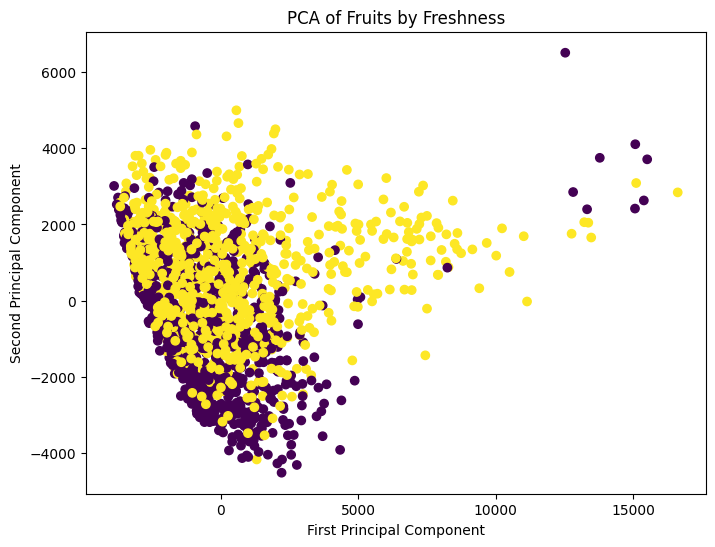

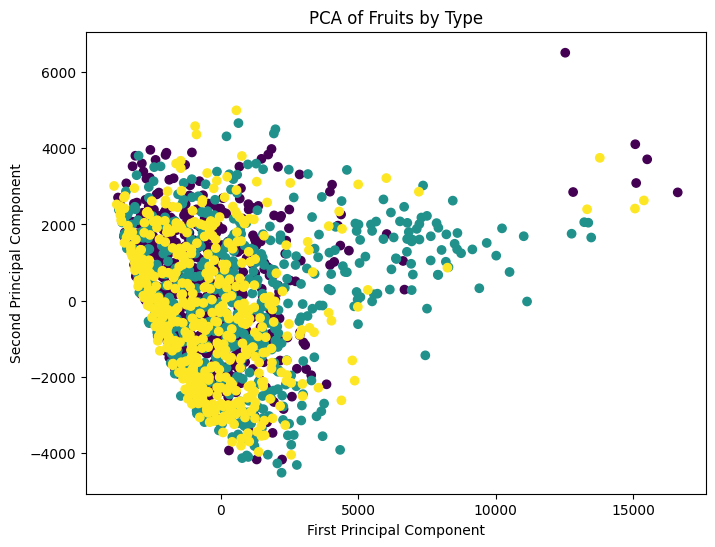

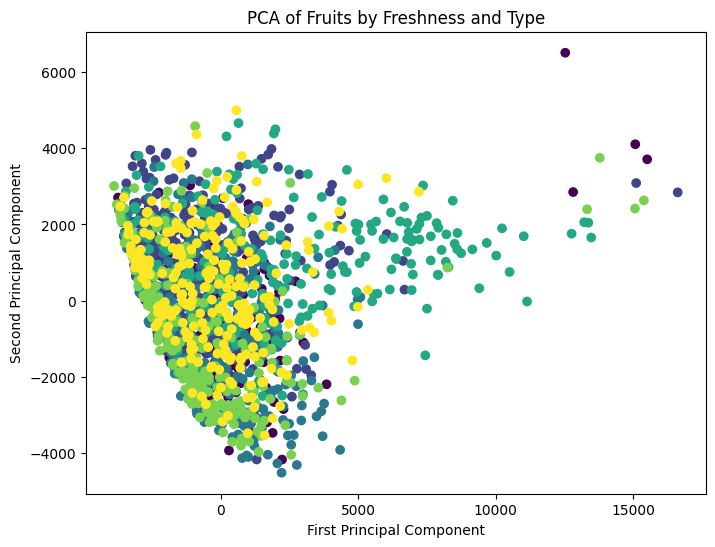

In [353]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
 
# Perform PCA
pca = PCA(n_components=2)
data_set_pca = pca.fit_transform(data_set)

# Plot the PCA
plt.figure(figsize=(8, 6))  
plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[0] == 'fresh' else 1 for x in dataset_target])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.title('PCA of Fruits by Freshness')

plt.show()

# PCA of fruits by type
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[1] == 'peach' else 1 if x[1] == 'pomegranate' else 2 for x in dataset_target])

plt.title('PCA of Fruits by Type')

plt.show()

#Label axes
# PCA of fruits by freshness and type
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(data_set_pca[:, 0], 
            data_set_pca[:, 1],
            c=[0 if x[0] == 'fresh' and x[1] == 'peach' else 1 if x[0] == 'rotten' and x[1] == 'peach' else 2 if x[0] == 'fresh' and x[1] == 'pomegranate' else 3 if x[0] == 'rotten' and x[1] == 'pomegranate' else 4 if x[0] == 'fresh' and x[1] == 'strawberry' else 5 for x in dataset_target])

plt.title('PCA of Fruits by Freshness and Type')

plt.show()



We initially tried to use PCA to try to reduce the dimensionality of the the images by using only 2 dimensions. However, we found that the images were not well suited for 2 dimensional PCA. Plotted above are the graphs showing different coloring of the images based on the different classifications. We can see that the images are not well separated and that 2-dimensional PCA is not a good way to reduce the dimensionality of the images. This led us to try to increase the number of dimensions to 3 which is shown in the next section.

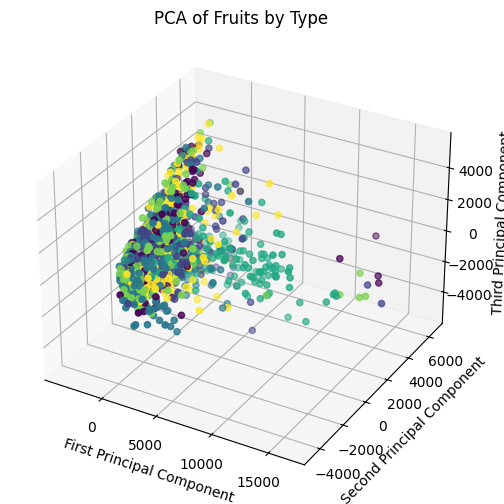

In [354]:
# PCA with 3 components
pca = PCA(n_components=3)
pca.fit(data_set)
data_set_pca = pca.transform(data_set)

# Plot the PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_set_pca[:, 0], 
           data_set_pca[:, 1], 
           data_set_pca[:, 2], 
           c=[0 if x[0] == 'fresh' and x[1] == 'peach' else 1 if x[0] == 'rotten' and x[1] == 'peach' else 2 if x[0] == 'fresh' and x[1] == 'pomegranate' else 3 if x[0] == 'rotten' and x[1] == 'pomegranate' else 4 if x[0] == 'fresh' and x[1] == 'strawberry' else 5 for x in dataset_target])

#Label axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

plt.title('PCA of Fruits by Type')

plt.show()


We can see a little bit of seperation between some of the classes but it is not enough to be useful for our purposes. Our next thought was to try to reduce the number of classes to see if that would help (for instance only comparing pomegranates and strawberries) which is shown in the next section.

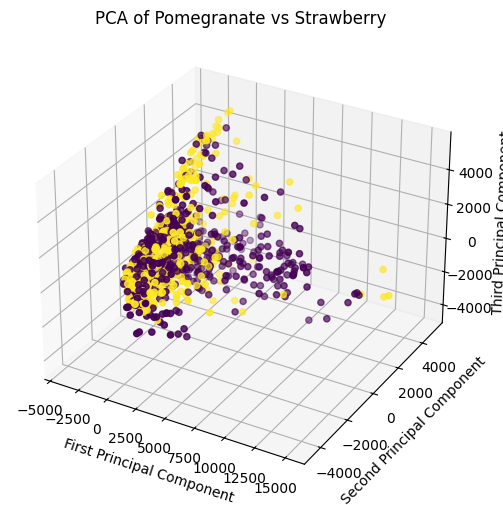

In [355]:
# PCA between pomegranate and strawberry only
pomegranate_strawberry = [x for x in dataset_target if x[1] in ['pomegranate', 'strawberry']]
pomegranate_strawberry_data = [data_set[i] for i, x in enumerate(dataset_target) if x[1] in ['pomegranate', 'strawberry']]
pca = PCA(n_components=3)
pca.fit(pomegranate_strawberry_data)
pomegranate_strawberry_data_pca = pca.transform(pomegranate_strawberry_data)

# Plot the PCA
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pomegranate_strawberry_data_pca[:, 0], pomegranate_strawberry_data_pca[:, 1], pomegranate_strawberry_data_pca[:, 2], c=[0 if x[1] == 'pomegranate' else 1 for x in pomegranate_strawberry])

#Label axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

plt.title('PCA of Pomegranate vs Strawberry')

plt.show()

As can be seen, we still were unable to get any useful information by using fewer classes. We then decided to try to use a different method to figure out exactly how many dimensions we should use to reduce the dimensionality of the images while still keeping the most information possible. We researched and found an article that suggested using the below method to determine the number of dimensions to use for PCA. We first plotted the cumulative explained variance ratio and outputted the number of dimensions needed to keep 85% of the variance.

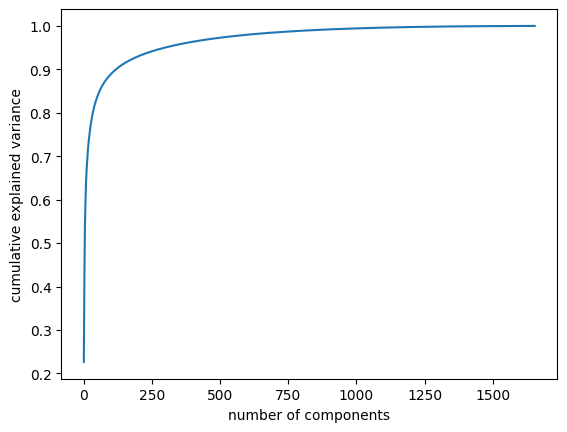

Number of components to explain 85% of the variance: 59


In [356]:
# Determine the number of components to use
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
pca = PCA().fit(data_set)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

#Label axes
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 85% of the variance
pca = PCA(0.85)
pca.fit(data_set)
print(f'Number of components to explain 85% of the variance: {pca.n_components_}')

We found that we needed to use 59 dimensions to explain 85% of the variance. Up until this point, we had been using the colored images to try to keep the most information possible. However, we decided to try to use the grayscale images to see if we could get better results. We then used the same method to determine the number of dimensions needed to keep 85% of the variance.

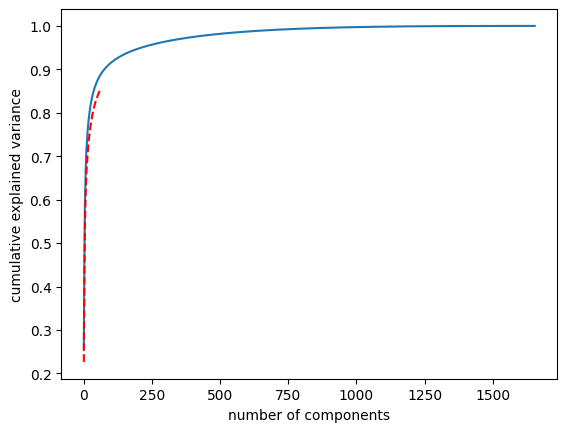

Number of components to explain 85% of the variance: 37


In [357]:
# Covert images to grayscale
data_set_gray = [cv2.cvtColor(x.reshape((h, w, 3)), cv2.COLOR_RGB2GRAY).flatten() for x in data_set]

# Compare the number of components to use
pca_grayscale = PCA().fit(data_set_gray)
plt.plot(np.cumsum(pca_grayscale.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r', linestyle='--')

#Label axes
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 80% of the variance
pca_grayscale = PCA(0.85)
pca_grayscale.fit(data_set_gray)
print(f'Number of components to explain 85% of the variance: {pca_grayscale.n_components_}')



As shown above, we did find that using the grayscale images did allow us to reduce the number of dimensions even further but for the future we still feel that using the colored images would lead to better performance of a model because the color can be such an important factor when differentiating between different fruits and in the freshness of the fruit.

# Randomized PCA

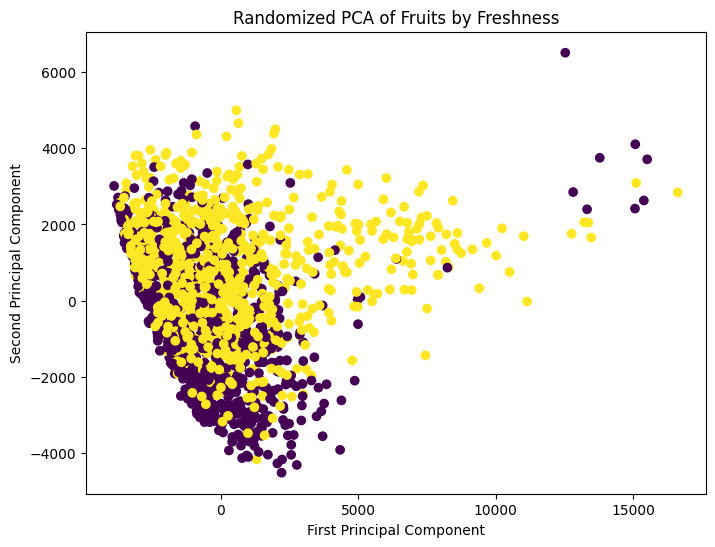

In [358]:
# Perform Randomized PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# Perform Randomized PCA
rand_pca = PCA(n_components=2, svd_solver='randomized')
data_set_pca = rand_pca.fit_transform(data_set)

# Plot the PCA
plt.figure(figsize=(8, 6))
plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[0] == 'fresh' else 1 for x in dataset_target])

#Label axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.title('Randomized PCA of Fruits by Freshness')

plt.show()

Again we see that 2-dimensional randomized PCA is still not a good way to reduce the dimensionality of the images. We decided to go ahead and try to determine the number of dimensions needed to keep 85% of the variance using the randomized PCA method using both the colored and grayscale images.

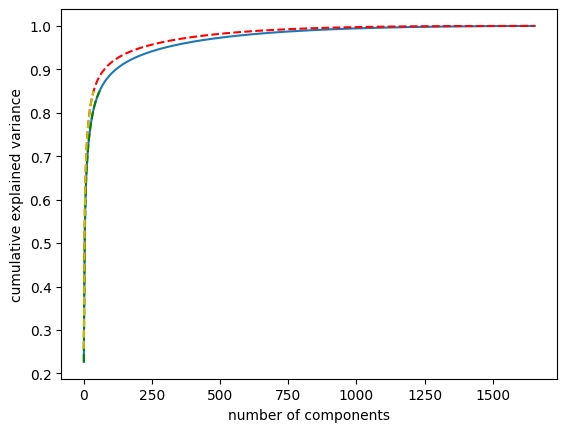

In [359]:
# Calculate the number of components to use
pca_randomized = PCA(svd_solver='randomized').fit(data_set)                     # Color
pca_randomized_grayscale = PCA(svd_solver='randomized').fit(data_set_gray)      # Grayscale

# Plot the number of components to use
plt.plot(np.cumsum(pca_randomized.explained_variance_ratio_))
plt.plot(np.cumsum(pca_randomized_grayscale.explained_variance_ratio_), 'r', linestyle='--')

# Plot the non-randomized PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'g', linestyle='--')
plt.plot(np.cumsum(pca_grayscale.explained_variance_ratio_), 'y', linestyle='--')

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

We prefer the standard method of PCA as randomized PCA is optimized for scalability and speed, two factors that are rather irrelevant to us. Randomized PCA is most useful for large, dense data sets that can't typically fit into memory. As our dataset does fit into memory, randomized PCA performs about the same as standard PCA, so we would rather use standard PCA. Our plot shows that the normal PCA on color images performs about the same as the randomzied PCA on the colored images. Furthermore, PCA and randomzied PCA work the best for gray scale data as well.

# Feature Extraction using DAISY

We will begin by simply visualizing the application of the DAISY function. After that, we will proceed to formally test its effectiveness. Below we plot a randomly chosen image by randomly choosing an index.

#### Visualizing DAISY

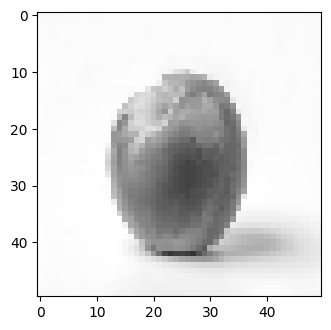

In [360]:
from skimage.io import imshow
import random as random

#Plotting code partially derived from Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
#Selecting an image to visualize the DAISY descriptor 
plt.subplot(1,2,1)
#Randomly choosing image to plot
idx_to_reconstruct = random.randint(0, len(data_set_gray))
img  = data_set_gray[idx_to_reconstruct].reshape(50,50)
plt.subplot(1,2,1)
imshow(img)
plt.grid(False)

We will be applying the DAISY function to images like the above. Below, we will visualize the DAISY descriptors of the image above.

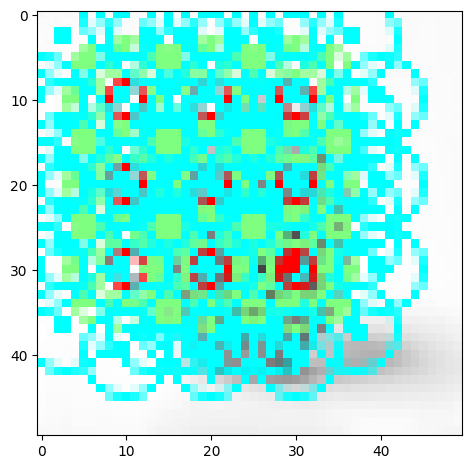

In [361]:
#Visualizing what the descriptor looks like
from skimage.feature import daisy

#Daisy function and its plot derived from Dr. Larson's GitHub
#After playing around with the parameters, these parameters led to the highest score for the classifier
#We will visualize the DAISY extraction for better understanding of the parameters
features, img_desc = daisy(img, 
                            step=10, 
                           radius=10, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)
plt.show()

Here, we are visualizing the application of the DAISY function onto the image selected from above. Now, we are going to apply the DAISY function to all of the images to extract features from the images. First, we will attempt to find the image closest matching the one selected using the DAISY features that we extracted. This will give us an idea of how well the DAISY function will perform on our data. Then we will attempt to measure how accurate the DAISY function is at classifying fruit type and freshness by running a k-nearest-neighbor multi-class multi-output classifier on the DAISY-applied data set.

#### Using DAISY to find the closest image

In [362]:
#Function from Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
#Creating a function that applies the daisy function to given data
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=10, radius=10, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

#Applying the daisy function to the grayscaled data
daisy_features = np.apply_along_axis(apply_daisy, 1, data_set_gray, (h,w))

In [363]:
from sklearn.metrics.pairwise import pairwise_distances
import copy

#Function partly derived from Dr. Larson's Github https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
def find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct):
    #Minimizing pairwise distances between daisy features to find closest image to the selected image
    dist_matrix = pairwise_distances(daisy_features)
    idx1 = idx_to_reconstruct
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty 
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    imshow(data_set_gray[idx1].reshape((h,w)))
    label1 = " ".join(dataset_target[idx1])
    plt.title("Original Image: "+ label1)
    plt.grid()

    plt.subplot(1,2,2)
    imshow(data_set_gray[idx2].reshape((h,w)))
    label2 = " ".join(dataset_target[idx2])
    plt.title("Closest Image: " + label2)
    plt.grid()

We will now use this function to visualize how effective the DAISY function is when using it to extract features from our data. We will apply this to three images.

#### Visualizing closest matches of random images using DAISY

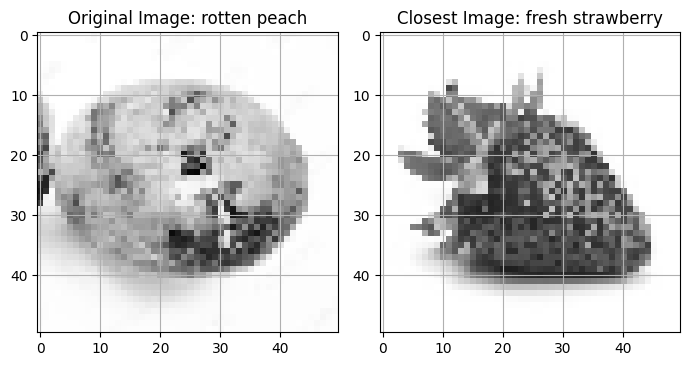

In [364]:
#Randomly selecting an integer in order to randomly select an image by index
idx_to_reconstruct = random.randint(0, len(data_set_gray))

find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct)

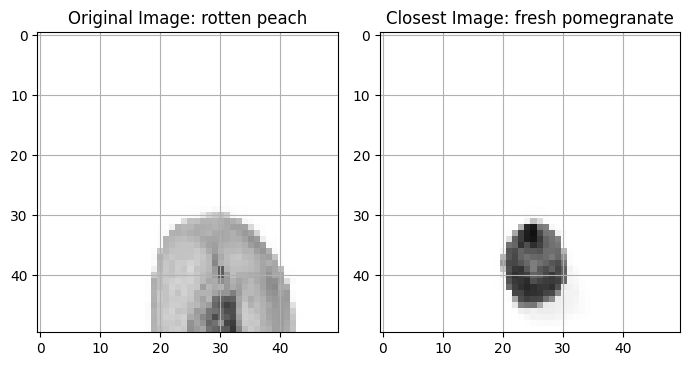

In [365]:
idx_to_reconstruct = random.randint(0, len(data_set_gray))

find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct)

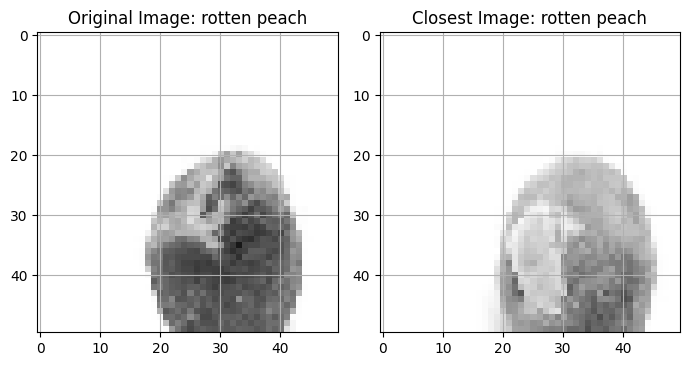

In [366]:
idx_to_reconstruct = random.randint(0, len(data_set_gray))

find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct)

#### Initial Analysis of DAISY Feature Extraction

While the DAISY function struggles to consistently match a correct label, it does capture the general shape quite accurately. In all of our visualizations, the matched fruit is located roughly in same grid as the originally selected fruit. Therefore, DAISY seems to be quite effective at matching the position of extracted features, at the very least. However, with poor label matching, particularly of the fruit freshness, in a business setting where it is important to determine if fruit has gone rotten, DAISY will likely not be the most effective choice at classifying fruits. We don't expect the DAISY feature extracting to perform well, particularly because color is not taken into account. Color is a huge factor in determining if a fruit is rotten, as the vibrant colors will sharply decline to dull colors. Furthermore, Color can be used to classify between the different types of fruits. The white spots of a strawberry or yellow and pink washes of a peach can be huge indicators in determining the type of fruit. We would be better off using a different feature extraction method that takes color into account. For the sake of study, though, we will perform a formal test of applying the DAISY function on our data. In our k-nearest-neigbor classifier, we will be testing if our hypothesis that DAISY is a a poor method of feature extraction for our dataset is correct

### Nearest Neighbor Classifier

In [367]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

#Code partly derived from 
#https://stackoverflow.com/questions/55489792/multiclass-multioutput-is-not-supported-error-in-scikit-learn-for-knn-classifi
knn_dsy = KNeighborsClassifier(n_neighbors=3)
classifier_dsy = MultiOutputClassifier(knn_dsy, n_jobs=-1)

#Separating into training and test sets for the daisy-applied dataset and its target labels
dsy_train, dsy_test, labels_train, labels_test = train_test_split(daisy_features, dataset_target, test_size=0.2, train_size=0.8)

# Fitting the classifier with training data
classifier_dsy.fit(dsy_train,labels_train)

#Printing the classifier score
#The score represents that amount of accurately predicted labels with our classifier
print("DAISY classifier score:", classifier_dsy.score(dsy_test, np.array(labels_test)))

DAISY classifier score: 0.3595166163141994


#### KNN Conclusion

We used the MultiOutputClassifier as out target data has multiple labels for each data entry (freshness and fruit type). We then passed a KNN classifier as an argument into the MultiOutputClassifier and get results of roughly 40%

The results confirm our suspicion that DAISY is not the best method in order to classify our fruit type and freshness. With a consistent multi-class multi-output classifier score of about 40%, our accuracy is too low to ever justify the use of DAISY in a setting where an incorrect classification can get someone sick (by eating a rotten fruit). 

# Key Point Matching 

First we will create functions used to iterate through all of the images and match an image with the highest number of key points of the DAISY descriptors

In [368]:
from skimage.feature import match_descriptors

#Function provided by Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=5, radius=5, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

The code below will be executed every time we iterate through an image in the data. This of course will lead to a brute force pairing of images

In [369]:
#Code partially derived from Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
def closest_match(source_img, source_idx, images, img_size):
    matched_idx = 0
    num_matches = 0
    #apply DAISY to image given
    source_daisy = apply_daisy(source_img, img_size)

    #Iterating through all other images to find the most similar image
    for i, img in enumerate(images):
        #Uses the index to prevent us from returning the original image as the 'most similar' iamge
        if i==source_idx:
            continue
        #apply DAISY to new image
        new_daisy = apply_daisy(img, img_size)

        #Key point matching on new DAISY-extracted image with original DAISY-extracted image
        matches = match_descriptors(source_daisy, new_daisy, cross_check=True, max_ratio=0.8)

        #if new image has more descriptor matches, set new image as best match to current image 
        if len(matches) > num_matches:
            num_matches = len(matches)
            matched_idx = i
    #Returns index of matched image
    #We will use this index to check if the labels match the source image's labels later
    return matched_idx


#### Visualizing image with highest number of key point matches with another image

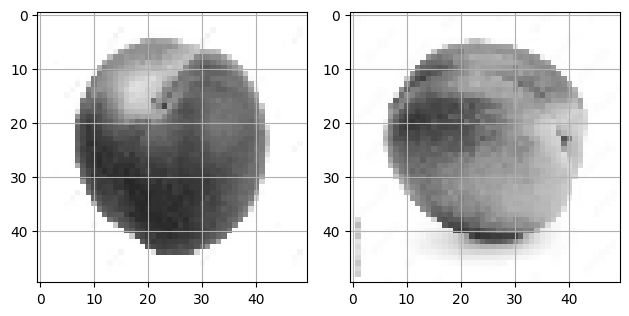

In [370]:
#Visualizing our function by plotting the first value and its most similar image in the dataset
#This is where we use the index that we returned from the function above
matched_index = closest_match(data_set_gray[0], 0, data_set_gray, (h,w))
matched_image = data_set_gray[matched_index].reshape(50,50)
plt.subplot(1,2,1)
imshow(matched_image)
plt.grid()

plt.subplot(1,2,2)
imshow(data_set_gray[0].reshape(50,50))
plt.grid()

Our function for finding matches appears to be working. At the very least, it preserves the general shape of the image we chose. We will now we will use the defined function above every time we iterate through image in order to find a best match for each image in our data. We will keep track of the correctly predicted labels and manually calculate its accuracy. Unfortunately, we will have to brute force match each possible pair of images in our data.

In [371]:
%time

#Keeps track of the correctly predicted values
preds = 0
#Length of the data. we will divide the correctly predicted values by this
count = len(data_set_gray)

#Iterating through each image in the data 
#This brute force matches each image with every other possible image in the data
#This will be incredibly time intensive...
for i in range(0, len(data_set_gray)):
    source_img = data_set_gray[i]

    matched_idx = closest_match(source_img, i, data_set_gray, (h,w))

    #If the label of the match is the same as the source image, add a value to the preds int
    #This keeps track of the correctly predicted values
    if dataset_target[matched_idx] == dataset_target[i]:
        preds += 1

CPU times: total: 0 ns
Wall time: 0 ns


In [372]:
# Manually calculating our accuracy by divided the correctly predicted labels by the total amount of labels.
accuracy = preds/count
print("Accuracy of key point matching of DAISY descriptors:", accuracy)

Accuracy of key point matching of DAISY descriptors: 0.4205438066465257


# Conclusion

To calculate the code above, it took 41 minutes and 44.2 seconds. With an accuracy rate of 42%, it is hardly any better than our original use of the DAISY function which took only seconds. Consequently, we would not be using this in a real situation where we had to classify rotten fruit. First, brute force matching each image with every other image took so much time. Secondly, even if we used the quick method of feature extraction using DAISY, it would still not be accurate enough to use in our situation. In our hypothetical situation, the stakes of someone getting sick are way too  high. Rather, through this experiment, we have shown that the DAISY function of feature extraction is better suited for image data when searching for general shapes of images that our similar. To find a trustworthy method of feature extraction in our situation of fruit/freshness classification, further study is needed into other more accurate methods of feature extraction for classification.

In our future endeavors of finding a feature extractor, we consider color to be particularly important for this data set. Color helps determine if a fruits natural vibrant color is rotting to a darker and dull color. Color also helps determine the fruit type as our peaches specifically can be distinguished by their yellow and pink skins.

# Sources
- https://www.kaggle.com/datasets/alihasnainch/fruits-dataset-for-classification
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
- https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
- https://stackoverflow.com/questions/55489792/multiclass-multioutput-is-not-supported-error-in-scikit-learn-for-knn-classifi
